In [11]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta
import statistics as stats 

import matplotlib.pyplot as plot
import networkx as nx
import seaborn as sns
import matplotlib.ticker as mtick

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [2]:
K_set = 3
T_set = 10
I_set = 4 #note there are actually 12 Supplier_SKUS but for ease I just say 4, 
#because in this example item types are supplied by the same suppliers
#supplier_SKU_set = 12

In [3]:
dem_dictionary_k = {1: [40000, 80000, 50000],
                    2: [40000, 80000, 50000],
                    3: [40000, 80000, 50000]
}

#define supply attributes
#capacity
cap_dictionary_supplier_SKU = {1: [9000,11000,10000], #min, max, likely, a,b,c
                     2: [10000,20000,15000], 
                     3: [13000,20000,17000],
                     4: [40000,100000,60000]}


#lead-time
lead_time_dictionary_supplier_SKU = {1: [3,5,4], #min, max, likely, a,b,c
                     2: [1,3,2], 
                     3: [3,5,4],
                     4: [0,2,0]}

#dynamic adj
dynamic_adj_dem = [0.5, 0.55, 0.6, 1, 1.1, 1.5, 1.6, 1.2, 1.1, 0.85]
dynamic_adj_supply = np.zeros(T_set)
for t in range(1, T_set+1):
    if dynamic_adj_dem[t-1] < 1:
        dynamic_adj_supply[t-1] = 1+(1-dynamic_adj_dem[t-1])
    else:
        dynamic_adj_supply[t-1] = 2-dynamic_adj_dem[t-1]

budget = 500000*K_set
warehouse_cap_level = 1.5*K_set #time intervals of expected supply needed that can be stored
reliability_level = .75
dynamic = True

#supplier-SKU names
#names_supplier_SKU = ['Supplier 1 - SKU: N95-MG', 'Supplier 1 - SKU: N95-N', 
# 'Supplier 2 - SKU: SUR-MG', 'Supplier 2 - SKU: SUR-N']

In [4]:
def triangular_dist_demand(a,b,c,prob):
    if prob <= (c-a)/(b-a):
        return(a+((((prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((1-prob)*(b-a)*(b-c))**(1/2)))

In [5]:
def triangular_dist_supply(a,b,c,prob):
    if 1-prob <= (c-a)/(b-a):
        return(a+((((1-prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((prob)*(b-a)*(b-c))**(1/2)))

In [6]:
def lead_time_dist(a,b,c):
    lead_time_dist_array = np.zeros(T_set+1)
    cum_prob = 0
    t = 0
    
    while t < b+1:
        if t+1 <= a:
            t = t+1 
        elif (a < t+1 & t+1 <= c):
            cum_prob_temp = ((t+1-a)**2)/((b+1-a)*(c-a))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
        elif c < t+1 & t+1 <= b+1:
            cum_prob_temp = 1-((b+1-(t+1))**2)/((b+1-a)*(b+1-c))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
    
    return(lead_time_dist_array)

In [7]:
#define parameters

###health care commodity metric parameters####
#rank
r_k_dict = {
    1 : 1,
    2 : 2,
    3 : 3
}

#quality 
q_k_i_dict = {}


for k in range(1,K_set+1):
    for i in range(1, I_set+1):
        if i == 1:
            q_k_i_dict[tuple([k,i])] = 1.3
        elif i == 2:
            q_k_i_dict[tuple([k,i])] = 1.2
        elif i == 3:
            q_k_i_dict[tuple([k,i])] = 1.2
        else:
            q_k_i_dict[tuple([k,i])] = 1.1


####Supply Parameters#####

#lead time (supplier 3 has the lowest lead time)
f_k_i_tDiff_dict = {}

for k in range(1,K_set+1):
    for i in range(1,I_set+1):
        lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                              lead_time_dictionary_supplier_SKU.get(i)[1],
                                              lead_time_dictionary_supplier_SKU.get(i)[2])
        for t in range(0,T_set+1):
            f_k_i_tDiff_dict[tuple([k,i,t])] = lead_time_dist_array[t]


#incoming orders
o_k_i_t_dict = {}

for k in range(1,K_set+1):
    for i in range(1,I_set+1): 
        for t in range(1,T_set+1):
            if t <= 2:
                o_k_i_t_dict[tuple([k,i,t])] = 0 #20000/4 #5000
            else:
                o_k_i_t_dict[tuple([k,i,t])] = 0



#lead time (supplier 1 has the higest capacity)
CAP_k_i_t_dict = {}

for k in range(1,K_set+1):
    for i in range(1,I_set+1): 
        cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                          cap_dictionary_supplier_SKU.get(i)[1],
                                          cap_dictionary_supplier_SKU.get(i)[2],
                                          reliability_level)
        if (dynamic == True):
            for t in range(1,T_set+1):
                cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
                CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp_2
        else:
            for t in range(1,T_set+1):
                CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp

####Demand Parameters####
n_k_init_dict = {
    1 : 0,
    2 : 0,
    3 : 0
}


#demand RV
D_k_t_dict = {}
for k in range (1, K_set+1):
    demand_temp = triangular_dist_demand(dem_dictionary_k.get(k)[0],
                                         dem_dictionary_k.get(k)[1],
                                         dem_dictionary_k.get(k)[2],
                                         reliability_level)
    if (dynamic == True):
        for t in range(1,T_set+1):
            demand_temp_2 =demand_temp*dynamic_adj_dem[t-1]
            D_k_t_dict[tuple([k,t])] = demand_temp_2
    else:
        for t in range(1,T_set+1):
            D_k_t_dict[tuple([k,t])] = demand_temp


#starting inventory
z_k_i_init_dict = {}

for k in range(1,K_set+1):
    for i in range(1,I_set+1):
        z_k_i_init_dict[tuple([k,i])] = 80000/4

#size
s_k_dict = {
    1 : 1,
    2 : 1,
    3 : 1
}

#warehouse capacity
h = 80000*warehouse_cap_level 

#cost
c_k_i_dict = {}

for i in range(1,I_set+1):
    for k in range(1,K_set+1):
        if i == 1:
            c_k_i_dict[tuple([k,i])] = 2
        elif i == 2:
            c_k_i_dict[tuple([k,i])] = 1.5
        elif i == 3:
            c_k_i_dict[tuple([k,i])] = 1
        else:
            c_k_i_dict[tuple([k,i])] = .8

b = budget

In [8]:
model = ConcreteModel()

#####define sets#######
model.K = Set(initialize = range(1,K_set+1))
model.I = Set(initialize = range(1,I_set+1))
model.T = Set(initialize = range(1,T_set+1))
model.T_0 = Set(initialize = range(0,T_set+1))

####initialize parameters####

def rank_param_initialize(model, k):
    return(r_k_dict.get(k))

model.r_k = Param(model.K, initialize = rank_param_initialize)

def discount_param_initialize(model, k, t):
    discount_temp = 1/model.r_k[k]
    return(1/((1+discount_temp)**(t)))

model.tau_k_t = Param(model.K, model.T_0, initialize = discount_param_initialize)

#model.tau_k_t.pprint()

def essentiality_param_initialize(model, k):
    return(1/model.tau_k_t[k, T_set])
    
model.e_k = Param(model.K, initialize = essentiality_param_initialize)

def quality_param_initialize(model, k, i):
    return(q_k_i_dict.get(tuple([k,i])))

model.q_k_i = Param(model.K, model.I, initialize = quality_param_initialize)

#model.q_k_i.pprint()

def delay_dist_param_initialize(model, k, i, t):
    return(f_k_i_tDiff_dict.get(tuple([k,i,t])))

model.f_k_i_tDiff = Param(model.K, model.I, model.T_0, 
                          initialize = delay_dist_param_initialize)

#model.f_k_i_tDiff.pprint()

def incoming_orders_initialize(model, k, i, t):
    return(o_k_i_t_dict.get(tuple([k,i,t])))

model.o_k_i_t = Param(model.K, model.I, model.T, initialize = incoming_orders_initialize)

#model.o_k_i_t.pprint()

def supplier_cap_param_initialize(model, k, i, t):
    return(CAP_k_i_t_dict.get(tuple([k,i,t])))

model.cap_k_i_t = Param(model.K, model.I, model.T, initialize = supplier_cap_param_initialize)

#model.cap_k_i_t.pprint()

def unfulfilled_demand_param_initialize(model, k):
    return(n_k_init_dict.get(k))

model.n_k_intialize = Param(model.K, initialize = unfulfilled_demand_param_initialize)

#model.n_k_intialize.pprint()

#assume preparing for one sd above the mean
def demand_param_initialize(model, k, t):
    return(D_k_t_dict.get(tuple([k,t])))

model.d_k_t = Param(model.K, model.T, initialize = demand_param_initialize)

#model.d_k_t.pprint()

def beg_inv_param_initialize(model, k, i):
    return(z_k_i_init_dict.get(tuple([k,i])))

model.z_k_i_init = Param(model.K, model.I, initialize = beg_inv_param_initialize)

#model.z_k_i_init.pprint()

def item_size_param_initialize(model, k):
    return(s_k_dict.get(k))

model.s_k = Param(model.K, initialize = item_size_param_initialize)

#model.s_k.pprint()

def warehouse_cap_param_initialize(model):
    return(h)

model.h = Param(initialize = h)

#model.h.pprint()

def cost_param_initialize(model, k, i):
    return(c_k_i_dict.get(tuple([k,i])))

model.c_k_i = Param(model.K, model.I, initialize = cost_param_initialize)

#model.c_k_i.pprint()

def budget_param_initialize(model):
    return(b)

model.b = Param(initialize = budget_param_initialize)

#model.b.pprint()

####initialize variables####
model.x_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount ordered
model.y_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount recieved
model.z_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
model.n_k_t = Var(model.K, model.T, model.T_0, within = NonNegativeReals)
model.m_k_i_t = Var(model.K, model.I, model.T, model.T_0, within = NonNegativeReals)

In [9]:
#def initialize_objective(model):
model.Objective = Objective(expr = 
                            (sum(model.e_k[k]*model.q_k_i[k,i]*sum(model.tau_k_t[k,t-1]*model.m_k_i_t[k,i,t, t_req] 
                                                      for t in model.T for t_req in range(0,t+1)) 
                                 for i in model.I for k in model.K)),
                            sense = maximize)

In [10]:
def incoming_orders_constraint_initialize(model, k, i, t):
    return(model.y_k_i_t[k,i,t] - 
           sum(model.f_k_i_tDiff[k, i, t-t_ordered_time]*model.x_k_i_t[k,i,t_ordered_time] 
               for t_ordered_time in range(1,t+1)) - model.o_k_i_t[k,i,t] == 0)

model.incoming_ordered_constraint = Constraint(model.K, model.I, model.T, 
                                               rule = incoming_orders_constraint_initialize)

In [11]:
def supplier_constraint_initialize(model, k, i, t):
    return(model.x_k_i_t[k,i,t] <= model.cap_k_i_t[k,i,t])

model.supplier_constraint = \
Constraint(model.K, model.I, model.T, rule = supplier_constraint_initialize)

In [12]:
def initalize_unsatisfied_demand_constraint_initialize(model, k):
    return(model.n_k_t[k,1,0] == model.n_k_intialize[k])

model.initalize_unsatisfied_demand_constraint= \
Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)

In [13]:
def calculate_unsatisfied_demand_constraint_initialize(model,k,t, t_req):
    if (t == t_req):
        return(model.n_k_t[k,t,t_req] == model.d_k_t[k,t] - \
               sum(model.m_k_i_t[k,i,t,t_req] for i in model.I))
    elif (t_req < t & t > 1):
        return(model.n_k_t[k,t,t_req] == model.n_k_t[k,t-1,t_req] -\
               sum(model.m_k_i_t[k,i,t,t_req] for i in model.I))
    else:
        return(Constraint.Skip)

model.calculate_unsatisfied_demand_constraint = \
Constraint(model.K, model.T, model.T_0, rule = calculate_unsatisfied_demand_constraint_initialize)

In [14]:
def beggining_inventory_constraint_initialize(model, k, i):
    return(model.z_k_i_t[k,i,1] == model.z_k_i_init[k,i])
    
model.beggining_inventory_constraint = Constraint(model.K, model.I, 
                                                  rule = beggining_inventory_constraint_initialize)

In [15]:
def calculate_available_inventory_constraint_initialize(model, k, i, t):
    if (t > 1):
        return(model.z_k_i_t[k,i,t] - model.z_k_i_t[k,i,t-1] - model.y_k_i_t[k,i,t-1] + 
               sum(model.m_k_i_t[k,i,t-1, t_hat] for t_hat in model.T_0) == 0)
    else:
        return(Constraint.Skip)
    
model.calculate_available_inventory_constraint = Constraint(model.K, model.I, model.T,
                                                            rule = 
                                                            calculate_available_inventory_constraint_initialize)

In [16]:
def cannot_fulfill_more_than_available_constraint_initialize(model, k,i,t):
    return(sum(model.m_k_i_t[k,i,t, t_hat] for t_hat in model.T_0) - model.z_k_i_t[k,i,t] <= 0)

model.cannot_fulfill_more_than_available_constraint = \
Constraint(model.K, model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)

In [17]:
def warehouse_capacity_constraint_initialize(model, t):
    return(sum(model.s_k[k]*model.z_k_i_t[k,i,t] for k in model.K for i in model.I) <= model.h)

model.warehouse_capacity_constraint = \
Constraint(model.T, rule = warehouse_capacity_constraint_initialize)

In [18]:
def budget_constraint_initialize(model):
    return(sum(model.c_k_i[k,i]*model.x_k_i_t[k,i,t] 
               for k in model.K for i in model.I for t in model.T) 
           <= model.b)

model.budget_constraint = \
Constraint(rule = budget_constraint_initialize)

In [19]:
opt = SolverFactory('gurobi_persistent')
opt.set_instance(model)
opt.solve(model)

Using license file /Users/chelseagreene/gurobi.lic
Academic license - for non-commercial use only - expires 2021-02-20


{'Problem': [{'Name': 'unknown', 'Lower bound': 179439347.060761, 'Upper bound': 179439347.060761, 'Number of objectives': 1, 'Number of constraints': 686, 'Number of variables': 2010, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 2010, 'Number of nonzeros': 4830, 'Sense': -1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.10', 'Status': 'ok', 'Wallclock time': 0.006577968597412109, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [20]:
#extract ordering df
ordered_df = pd.DataFrame(list(model.x_k_i_t.extract_values().items()),columns = ['sets','units_to_order'])
ordered_df.loc[:,'item_type']=ordered_df.sets.map(lambda x:x[0])
ordered_df.loc[:,'supplier']=ordered_df.sets.map(lambda x:x[1])
ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[2])

In [21]:
#extract expected arrivals df
recieved_df = pd.DataFrame(list(model.y_k_i_t.extract_values().items()),columns = ['sets','expected_units_recieved'])
recieved_df.loc[:,'item_type']=recieved_df.sets.map(lambda x:x[0])
recieved_df.loc[:,'supplier']=recieved_df.sets.map(lambda x:x[1])
recieved_df.loc[:,'time_interval']=recieved_df.sets.map(lambda x:x[2])

In [22]:
#extract expected fulfilled df
fulfilled_df = pd.DataFrame(list(model.m_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])
fulfilled_df.loc[:,'time_interval_req']=fulfilled_df.sets.map(lambda x:x[3])
fulfilled_df['delay'] = fulfilled_df['time_interval'] - fulfilled_df['time_interval_req']

In [23]:
#extract expected available df
available_df = pd.DataFrame(list(model.z_k_i_t.extract_values().items()),columns = ['sets','units_available'])
available_df.loc[:,'item_type']=available_df.sets.map(lambda x:x[0])
available_df.loc[:,'supplier']=available_df.sets.map(lambda x:x[1])
available_df.loc[:,'time_interval']=available_df.sets.map(lambda x:x[2])

In [24]:
#extract expected unsatisfied df
unsatisfied_df = pd.DataFrame(list(model.n_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])

In [25]:
demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()), columns = ['sets', 'demand_in_units'])
demand_df.loc[:,'item_type']=demand_df.sets.map(lambda x:x[0])
demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])

In [26]:
ordered_and_recieved_df = ordered_df[['item_type', 'supplier', 'time_interval', 'sets']]
ordered_and_recieved_df = ordered_and_recieved_df.merge(recieved_df[['sets', 'expected_units_recieved']],
                                                        on='sets', how='left')
ordered_and_recieved_df = ordered_and_recieved_df.merge(ordered_df[['sets', 'units_to_order']],
                                                        on='sets', how='left')

ordered_and_recieved_df = ordered_and_recieved_df[['item_type', 'supplier', 
                                                   'time_interval','units_to_order', 
                                                   'expected_units_recieved']]

ordered_and_recieved_df['units_to_order'] = (round(ordered_and_recieved_df['units_to_order'])).astype(int)
ordered_and_recieved_df['expected_units_recieved'] = (round(ordered_and_recieved_df['expected_units_recieved'])).astype(int)

In [27]:
#os.chdir(results_dir)
ordered_and_recieved_df.to_csv('ordering_and_recieving_schedule.csv')

recieved_df.to_csv('recieving_schedule.csv')
ordered_df.to_csv('ordering_schedule.csv')

In [28]:
#for k in range(1,K+1):
unsatisfied_temp_df = unsatisfied_df[unsatisfied_df['item_type'] == 1].groupby(['time_interval'])['units_unsatisfied']\
.sum().reset_index()
fulfilled_temp_df = fulfilled_df[fulfilled_df['item_type'] == 1].groupby(['time_interval'])["units_fulfilled"]\
.sum().reset_index()
available_temp_df = available_df[available_df['item_type'] == 1].groupby(['time_interval'])["units_available"]\
.sum().reset_index()

In [29]:
fulfilled_df_item_time = fulfilled_df.groupby(['item_type', 
                                               'time_interval'])['units_fulfilled'].sum().reset_index()
unsatisfied_df_item_time = unsatisfied_df.groupby(['item_type', 
                                                   'time_interval'])['units_unsatisfied'].sum().reset_index()

In [30]:
reliability_df = pd.merge(fulfilled_df_item_time[['item_type', 'time_interval', 'units_fulfilled']], 
                          unsatisfied_df_item_time[['item_type', 'time_interval', 'units_unsatisfied']], 
                          how='left', on=['item_type','time_interval'])

reliability_df['total_number_of_open_requests'] = reliability_df['units_fulfilled'] +\
reliability_df['units_unsatisfied'] 

reliability_df['percent_unsatisfied'] = \
reliability_df['units_unsatisfied']/reliability_df['total_number_of_open_requests']

In [31]:
reliability_df.groupby(['item_type'])['percent_unsatisfied'].mean().reset_index()

,item_type,percent_unsatisfied
0,1,0.101870
1,2,0.166491
2,3,0.342247


In [4]:
os.chdir('/Users/chelseagreene/github/epi_supplychain_optimization/inventory_management/model/publication/example_ouputs')

In [5]:
budget_limitation_graph = pd.read_csv('budget_limitation_example.csv')
budget_limitation_graph = budget_limitation_graph.head(6)
budget_limitation_graph['Item Type'] = (budget_limitation_graph['Item Type']).astype(int)
budget_limitation_graph['Essentiality Rank'] = (budget_limitation_graph['Essentiality Rank']).astype(int)

In [9]:
budget_limitation_graph['Percent Unsatisfied'] = budget_limitation_graph['Percent Unsatisfied']*100

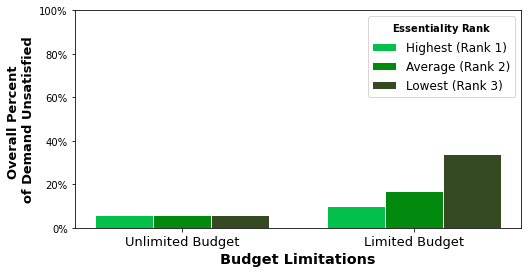

In [26]:
fig, ax = plot.subplots(figsize=(8,4))

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = budget_limitation_graph[budget_limitation_graph['Item Type'] == 1]['Percent Unsatisfied']
bars2 = budget_limitation_graph[budget_limitation_graph['Item Type'] == 2]['Percent Unsatisfied']
bars3 = budget_limitation_graph[budget_limitation_graph['Item Type'] == 3]['Percent Unsatisfied']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

 
# Make the plot
plot.bar(r1, bars1, color='#03C04A', 
         width=barWidth, edgecolor='white', label='Highest (Rank 1)')
plot.bar(r2, bars2, color='#028A0F', 
         width=barWidth, edgecolor='white', label='Average (Rank 2)')
plot.bar(r3, bars3, color='#354A21', 
         width=barWidth, edgecolor='white', label='Lowest (Rank 3)')
 
# Add xticks on the middle of the group bars
plot.xlabel('Budget Limitations', fontweight='bold', fontsize='x-large')
plot.ylabel('Overall Percent \nof Unsatisfied Demand', fontweight='bold', fontsize = 13)
plot.xticks([r + barWidth for r in range(len(bars1))], ['Unlimited Budget', 'Limited Budget'], fontsize = 13)
ax.yaxis.set_ticks(np.arange(0, 120, 20))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
# Create legend & Show graphic
plot.legend(title = r'$\bf{Essentiality~Rank}$', fontsize='large', fancybox=True)
plot.show()